<a href="https://colab.research.google.com/github/RodolfoFerro/hyperspectrum/blob/master/Day%203/Process_selfies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Let's combine all the tools we've learned about to process some images! 
In this notebook, we'll use some algorithms to align the hyperspectral images we captured today. We'll then display the images using opencv.

First, we'll import all the libraries we need to use:

In [0]:
from skimage import io                       # Used to open the hyperspectral image
from glob import glob                        # This can add all the file names into one list automatically
import numpy as np                           # This library contains all the array manipulation tools
import cv2                                   # The OpenCV module, containing all the computer vision tools we need
from google.colab.patches import cv2_imshow  # A patched version of opencv imshow that works on google colab
from google.colab import drive               # Allows us to mount the google drive folder

Let's first mount our folder onto the local file system. Make sure to follow the steps correctly:


In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now let's create list of the file names so we can access them later

In [0]:
imgs = glob('/content/drive/My Drive/Clubes 2019/Hyperspec_Tiffs/TCA000[3-7]*.TIF')
print(len(imgs)) # This is to check the length of the list, to make sure it's the right size

44


Now we will apply two different alignment algorithms. The first one is based on homography (see https://en.wikipedia.org/wiki/Homography_(computer_vision) and https://docs.opencv.org/master/d9/dab/tutorial_homography.html). 
Another one correlates the images together based on the phase of edges. 

Here we'll set the warpmode when we apply the warp matrix to the images

Then we define a 3x3 identiy matrix as the initial warp matrix


In [0]:
warpmode = cv2.MOTION_HOMOGRAPHY
warpmatrix0 = np.eye(3,3,dtype=np.float32)

Now we set the accuracy of the alighment for the homography alignment.

We first define criteria for when to stop finding the best warp matrix.

We'll tell the algorithm to stop when the difference of the iteration is 0.00001

We'll set the maximum iterations to 10000 iterations for fitting

In [0]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 1e-5)

Now let's do some fitting on an image. We'll go with the first image in the list. We'll use the `io` package from `skimage` library to open the hyperspectral tiff image. We can also convert the image to unsigned intergers for displaying purposes here. 

In [0]:
f = io.imread(imgs[0])
f = (f/np.amax(f)*255).astype(np.uint8)

Let's choose one reference image to align the other 6 image to. We'll choose the IR 800 nm image, which is extension 0. We'll align all other extensions of the image to this one. 


We'll detect the edges of this image using Canny edge detection algorithm (https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html). We'll set the limits to 200 and 300, but we should experiment until we're satisfied with the final results.

In [0]:
exts = [1,2,3,4,5]
refedges = cv2.Canny(f[0],200,300)

We also have to enlarge the "Thermal" image, since it's about 1/3 smaller than the rest of the image. We'll first enlarge the image by 33%, then we have to crop the image so it maintains it's original size using array slicing. The opencv resize function fills in the new pixels based on surrounding pixels of the new ones using interpolation (https://en.wikipedia.org/wiki/Spline_interpolation). We'll choose spline cubic interpolation.

In [0]:
f[6] = cv2.resize(f[6],None,fx=1.33,fy=1.33,interpolation=cv2.INTER_CUBIC)[169:1193,211:1491]

Now let's align the rest of the images  in the extensions found in `exts`. We'll find the edges in the rest of the images, find a warpmatrix using the Enhanced Correlation Coefficient algorithm (http://xanthippi.ceid.upatras.gr/people/psarakis/publications/PAMI.pdf), then warp each image based on this warp matrix.

In [0]:
for ext in exts:
    print("Aligning extension "+str(ext))
    edges = cv2.Canny(f[ext].astype(np.uint8),200,300)
    print("Found edges")
    (cc, warpmatrix) = cv2.findTransformECC(refedges,edges,warpmatrix0,warpmode,criteria)
    print("Determined transformation matrix")
    f[ext] = cv2.warpPerspective(f[ext],warpmatrix,f[ext].shape[::-1],flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    print("Aligned Image")

Aligning extension 1
Found edges
Determined transformation matrix
Aligned Image
Aligning extension 2
Found edges
Determined transformation matrix
Aligned Image
Aligning extension 3
Found edges
Determined transformation matrix
Aligned Image
Aligning extension 4
Found edges
Determined transformation matrix
Aligned Image
Aligning extension 5
Found edges
Determined transformation matrix
Aligned Image


Now let's merge our aligned images into a blue, green, red image and then display it:

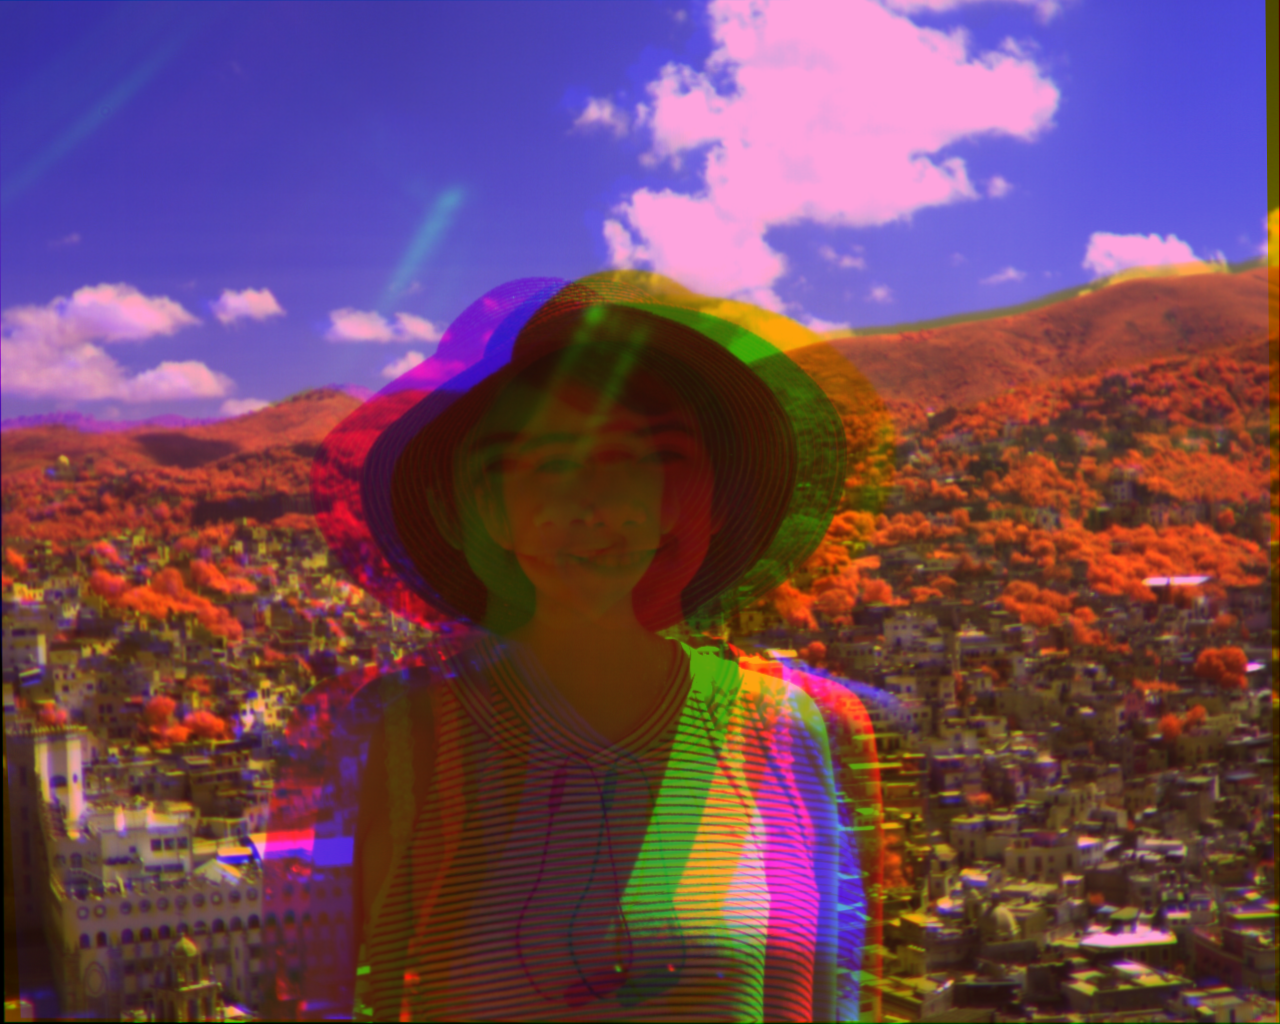

In [0]:
BGR = cv2.merge((f[1],f[4],f[5]))
cv2_imshow(BGR)

We can also try the phase-correlation algorithm. We apply a similar algorithm, except we will shift the image to match the phase of the edges instead of warping the image based on the ECC algorithm from eges.

In [0]:
f = io.imread(imgs[0])
f[6] = cv2.resize(f[6],None,fx=1.33,fy=1.33,interpolation=cv2.INTER_CUBIC)[169:1193,211:1491]
f = (f/np.amax(f)*255).astype(np.uint8)
exts = [1,2,3,4,5,6]
refedges = cv2.Canny(f[0],200,300)

for ext in exts:
    print("Aligning extension "+str(ext))
    edges = cv2.Canny(f[ext].astype(np.uint8),200,300)
    print("Found edges")
    corr = cv2.phaseCorrelate(edges.astype(np.float32),refedges.astype(np.float32))
    print("Found correlation offset")
    f[ext] = cv2.warpAffine(f[ext],np.float32([[1,0,corr[0][0]],[0,1,corr[0][1]]]),(1280,1024))
    print("Aligned Image")

BGR = cv2.merge((f[1],f[4],f[5]))
cv2_imshow(BGR)

And if all else fails, we can align images manually using the Affine transformation. Sometimes the auto-alignment doesn't align to the objects we want, so we can always default to manual. For example:

In [0]:
f[1] = cv2.warpAffine(f[1],np.float32([[1,0,-200],[0,1,-150]]),(1280,1024))
